In [40]:
"""
This version of the Variant Target Model results in a graph with (potentially)
many components (returned as G by human_family_network()) and a version with a
single weakly connected component (returned as G_connected by
human_family_network()) (see Chapter 5 in Kolton's thesis))

The main guts of the model are in the make_model() method.  There is
an example of how to run the model is on the bottom

This version new and updated, implementing a class structure 
(in hopes to make updating code more efficient)
"""

import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
import statistics
import time
import regex as re
import ast
import pickle
import os
from write_model_to_pajek_ore_graph import format_as_pajek
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import graphviz_layout


class HumanFamily:
    """
    PARAMETERS:
        name: (str) the name of the kinsources data set (see below for format)
    METHODS (To call on the object):
        HumanFamily(name): Initializes the model, recording data from the model "name"
        make_model(init_gen_size): Makes the model, given an initial size for the first generation
            if save=True, the distributions of distance to unions are stored in graphs in ouptut folder
            if method='BFS', the model will use the BFS method to form marriage unions
        build_single_component(): Builds a single component graph from the model
            if save=True, the distributions of distance to unions are stored in graphs in ouptut folder
    ATTRIBUTES:
        Initialized when the object is created:
            save (bool): should you save pickled versions of networkx graphs, model
                union edges, and distance to union and child distributions, as well
                as png graphs of distance to union updates each generation as well
                as an xlsx file summarizing model growth? should you print debug info?
            marriage_dists: (list of int) one entry per marriage indicating how many
                generations between spouses (reported in the number of parent-child
                edges crossed so that distance between siblings is 2) in the
                specified dataset.  If no common ancestor (IE an infinite distance)
                then the corresponding entry is -1
            num_marriages: (int) total number of marriage edges in the specified
                dataset
            prob_inf_marriage: (float) number of infinite marraiges divided by total
                number of marriages in the specified dataset
            prob_finite_marriage: (float) number of non-infinite marriages divided
                by total number of marriages in the specified dataset
            children_dist: (list of int) one entry per pair of parents, indicating
                how many child edges each parent in the couple share
            num_people_orig_graph: (int) total number of nodes in the real life data set.
            num_components: (list) to track the the number of components at each generation
        Created When the make_model() function is run
            num_people_setup (int): The number of people chosen to be in the first generation
            G (nx.DiGraph):  modeled network.  This graph can have MANY COMPONENTS.
                Each node has the following attributes: 1) layer: either an int
                    indicating the vertice's generation 2) immigrant: bool
                    indicating whether the vertex had parents in the graph when the
                    vertex was originally added to the graph.  All vertices in the
                    initial generation are immigrants, as are those brought in to
                    form additional infinite-distance unions. 3) parents: int in
                    {0, 1, 2}, counting the number of incoming parent-child type
                    edges.  When joining up components into a single component
                    (forming G_connected), we only allow immigrant vertices to have
                    at most two incoming ancestral lines (i.e. paternal and
                    maternal).
                Each edge has the following attributes: 1) Relationship: str, either
                    "Marriage" to indicate a union edge or "Parent-Child".  Again,
                    Parent-Child edges go from parent to child.
            full_target_distribution (dict): this stores the target distribution
                key: ditance to union, value: probability
            all_marriage_edges (list of tuples of int): this lists all union-type
                edges added to G (indicated by node attribute
                "Relationship"=="Marriage").  NOTE:  The auxiliary ancestry added
                prior to generation 0 contains no union-type edges, so that G and
                G_connected share the same list of union edges.
            all_marriage_distances (list of int): this lists all distances prior to
                union for each union edge in all_marriage_edges (orders match).
                NOTE: these distances are those as observed in G with auxiliary
                ancestry prior to generation 0.  These distances are also the
                distances for the unions in G_connected.
            all_children_per_couple (list of int): this lists the number of children
                per union edge in G and in G_connected.  NOTE: because the auxiliary
                ancestry contains no union edges, the parent-child relationships
                encoded therein do not affect this distribution.  That is, G and
                G_connected have the exact same list of children per union.
            out_dir (str): destination directory for save output.  Each run will
                create an out_dir/{name}_{int}/ file structure, counting version
                number automatically
            dies_out (bool):  False indicates that the model exited successfully---
                generations 0 to L (inclusive) contain more than when_to_stop nodes
                in total OR L >= num_gens.  True else.
            summary_statistics (tuple): Ordered tuples of integers 
                (# total people in graph,  # immigrants, # num_children, # num marriages, 
                self.prob_inf_marriage, self.prob_finite_marriage, self.prob_inf_marriage(eligible_only), 
                self.prob_finite_marriage(elegible_only))
            method (str): Used to tell make_model which method it should use when forming marraige unions
                'NetworkX' - Use Networkx BFS to find a mate of specified distance
                BFS - Do a BFS up the tree to determine which nodes to avoid while traversing done
            fixed (boolean): Used to determine if we use a fixed probability distribution or not
            generation_ranges: (list) Stores the largest person number in each generation 
                index: generation number
                value: total_num_people in generations 0-index
                Note: The initial generation of infinite distance people is gen 0
            imm_probs: (list) Store the proportion of nodes in infinite distance unions that are immigrants
                For generation 0, it is 0
                When all the infinite distance are possible, it is 0.1
                If more immigrants are needed to make it work, it is some unkown value
            errors: (list) Store the error between distributions at each iteration
            num_people (int): The number of people in the entire model
            tol (float)  # Stopping criteria 
                (the algorithm will stop when the difference between the erros is less than tol)
            eps (int)   # Allowed error
    """
    # Initialization function is same as get_graph_stats
    def __init__(self, name, save=True, distance_path='./Kolton_distances/', child_number_path='./ChildrenNumber/'):
        """
        Gets the statistics of a specified kinsources dataset
        PARAMETERS:
            name: (str) the name of the kinsources data set
            distance_path: (str) the filepath to the directory containing the saved
                text files containing the distance to marriage distributions (the output
                of timing_kolton_distance_algorithm.py)
            child_number_path: (str) the filepath to the directory containing the
                saved text files containing the children per couple distributions
        ATTRIBUTES (That it initializes):
            name: (str) the name of the kinsources data set
            save (bool): should you save pickled versions of networkx graphs, model
                union edges, and distance to union and child distributions, as well
                as png graphs of distance to union updates each generation as well
                as an xlsx file summarizing model growth? should you print debug info?
            marriage_dists: (list of int) one entry per marriage indicating how many
                generations between spouses (reported in the number of parent-child
                edges crossed so that distance between siblings is 2) in the
                specified dataset.  If no common ancestor (IE an infinite distance)
                then the corresponding entry is -1
            num_marriages: (int) total number of marriage edges in the specified
                dataset
            prob_inf_marriage: (float) number of infinite marraiges divided by total
                number of marriages in the specified dataset
            prob_finite_marriage: (float) number of non-infinite marriages divided
                by total number of marriages in the specified dataset
                NOTE: prob_finite_marriage + prob_inf_marriage + prob_single = 1
            children_dist: (list of int) one entry per pair of parents, indicating
                how many child edges each parent in the couple share
            num_people_orig_graph: (int) total number of nodes in the real life data set.
            num_components: (list) to track the the number of components at each generation
        """
        if save: print(f"Gathering Data From {name}.txt")
        with open(distance_path + '{}.txt'.format(name)) as infile:
            self.marriage_dists, num_inf_marriages, fraction_inf_marriage = [ast.literal_eval(k.strip()) for k in infile.readlines()]

        # number of children data of chosen network
        with open(child_number_path + '{}_children.txt'.format(name)) as f:
            nx_child = f.readline()

        self.name = name
        self.num_people_orig_graph = self.get_num_people()   # Get the number of people in the original graph
        if save: print(f"This Data Set Has {self.num_people_orig_graph} people")

        self.save = save
        self.children_dist = ast.literal_eval(nx_child)
        self.num_marriages = len(self.marriage_dists)
        prob_marriage = self.num_marriages * 2 / self.num_people_orig_graph  # *2 since 2 spouses per marriage
        self.prob_inf_marriage = prob_marriage * fraction_inf_marriage
        self.prob_finite_marriage = prob_marriage - self.prob_inf_marriage

    def reset(self):
        """
        Defaults back to status of the object before the make_model() function was called
        Used if you want to run a model on the same data set over and over again without reinitalizing
        """
        # Reset variables that may have been altered
        self.out_dir = None
        self.fixed = None
        self.eps = None
        self.num_people_setup = None
        self.method = None
        self.summary_statistics = None
        self.all_marriage_edges = None
        self.all_marriage_distances = None
        self.all_children_per_couple = None
        self.dies_out = None
        self.num_people = None

        # Initialize new variables for setting up
        self.full_target_distribution = {}
        self.num_components = []
        self.num_alive_components = []
        self.G = nx.DiGraph()   # Graph to store everyone
        self.generation_ranges = []   # Stores the largest person number in each generation [index: generation number, value: total_num_people]
        self.imm_probs = []   # Stores the probability of being an immigrant for a node in an infinite distance union
        self.num_immigrants_added = []   # Stores number of immigrants added in each generation
        self.errors = []   # to store the errors that we will use in a graph

    ##########################################################################
    # Work with directories (next 2 functions)
        
    def get_graph_path(self, path='./Original_Sources/'):
        """
        PARAMETERS:
            name: (str) the name of the kinsources data set (see below for format)
        RETURNS:
            path: (str) path to directory prepended to the full name of specified
                kinsources file
        """
        return path + 'kinsources-' + self.name + '-oregraph.paj'

    def makeOutputDirectory(self):
        """
        Make an output directory to keep things cleaner

        Returns a full output path to the new directory
        """
        ver = 1
        output_dir = os.path.join(self.out_dir, self.name + '_')
        while os.path.exists(output_dir + str(ver)):
            ver += 1
        output_dir += str(ver)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        return output_dir
    
    # Get graph stats
    def get_num_people(self):
        """
        gets the number of people (total number of verticies) in the .paj file
        This function assumes that the number of nodes is correctly reported in the
        3rd line (index 2) of the .paj file. For example, contents should begin in
        the following format (defined in the funtion below):
            ['*Network Ore graph Tikopia.puc\n',
            '\n',
            '*vertices 294\n',
            "1 'X (1)' ellipse\n",
            ...]

        PARAMETERS:
            name: (str) the name of the kinsources data set
        RETURNS:
            num_people: (int) total number of people in the graph
        """
        path_to_graph = self.get_graph_path()
        # open and read graph file
        with open(path_to_graph, 'r') as file:
            contents = file.readlines()

        num_people = contents[2]
        num_people_pattern = re.compile("[0-9]+")
        num_people = int(num_people_pattern.findall(num_people)[0])

        return num_people
    
    ##########################################################################
    # Plot things (next 7 functions)

    def plot_find_mate_stats(self, cum_successes, cum_accuracy):
        """
        Create plots of successes (how often the find_mate function finds a mate) and accuracy
        (how often the two candidates' geodesic distance matches the searched distance)
        against the searched distance.
        """
        accuracy_data = {val:list() for val in range(-1,50)}
        successes_data = {val:list() for val in range(-1,50)}

        # Aggregate statistics for successes (filtered by distance)
        # and similar for accuracies
        for successes in cum_successes:
            for dist in successes:
                successes_data[dist].extend(successes[dist])

        for accuracy in cum_accuracy:
            for dist in accuracy:
                accuracy_data[dist].extend(accuracy[dist])

        # Compute totals as well as percentages for each of the quantities.
        # Relate accuracy percentage to the total number of trials, rather than the total number of successful trials
        # (which is why we divide by len(successes_data[dist]))
        distances = range(-1,50)
        success_totals = [sum(successes_data[dist]) for dist in successes_data]
        accuracy_totals = [sum(accuracy_data[dist]) for dist in accuracy_data]
        success_perc = [sum(successes_data[dist])/len(successes_data[dist]) if len(successes_data[dist]) > 0 else 0 for dist in successes_data]
        accuracy_perc = [sum(accuracy_data[dist])/len(successes_data[dist]) if len(successes_data[dist]) > 0 else 0 for dist in accuracy_data]

        plt.suptitle(f"Distance Accuracy of {self.method} method for {self.name} dataset")
        plt.subplot(121)
        plt.title("Number of successes")
        plt.plot(distances, success_totals, "o-", label="Successes")
        plt.plot(distances, accuracy_totals, "o-", label="Accurate successes")
        plt.xlim((0,15))
        plt.xlabel("Desired Marriage Distance")
        plt.ylabel("Amount")
        plt.legend(loc="upper right")

        plt.subplot(122)
        plt.title("Percentage of successes")
        plt.plot(distances, success_perc, "o-", label="Successes")
        plt.plot(distances, accuracy_perc, "o-", label="Accurate successes")
        plt.xlim((0,15))
        plt.xlabel("Desired Marriage Distance")
        plt.ylabel("Proportion")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # plt.show()
        plt.clf()

    def plot_valid_path_stats(self, valid_path_stats):   # Only use this function if we don't force finite paths to be valid (commented out code in find_mate_NetworkX() function)
        """
        Ceeate plot to display the proportion of finite unions formed that were found using valid paths

        It is possible NetworkX method to incorrectly calculate the distance between two nodes. This is
        because it only takes in a directed graph. So, the shortest path between two nodes may bounce up and down. 
        """
        valid_path_data = {val:list() for val in range(-1,50)}

        # Aggregate statistics for successes (filtered by distance)
        # and similar for accuracies
        for valid_paths in valid_path_stats:
            for dist in valid_paths:
                valid_path_data[dist].extend(valid_paths[dist])

        # Compute totals as well as percentages for each of the quantities.
        # Relate accuracy percentage to the total number of trials, rather than the total number of successful trials
        # (which is why we divide by len(successes_data[dist]))
        distances = range(-1,50)
        total = [len(valid_path_data[dist]) for dist in valid_path_data]
        success_totals = [sum(valid_path_data[dist]) for dist in valid_path_data]
        success_perc = [sum(valid_path_data[dist])/len(valid_path_data[dist]) if len(valid_path_data[dist]) > 0 else 0 for dist in valid_path_data]

        plt.subplot(121)
        plt.title("Number of Finite Unions")
        plt.bar(distances, total, label="Incorrect Path Found", color="red")
        plt.bar(distances, success_totals, label="Valid Path Found")
        plt.xlim((0,15))
        plt.xlabel("Desired Marriage Distance")
        plt.ylabel("Total number")
        plt.legend(loc="upper right")

        plt.subplot(122)
        plt.title("Proportion of paths that are actually valid")
        plt.bar(distances, success_perc, color="orange")
        plt.xlim((0,15))
        plt.xlabel("Desired Marriage Distance")
        plt.ylabel("Proportion")

        plt.tight_layout()
        # plt.show()
        plt.clf()

    @staticmethod
    def plot_time_to_form_marraiges(time_to_form_marraiges):
        """
        Create plot of the time it takes each generation to form all of its marraiges

        PARAMETERS:
            time_to_form_marraiges (list): The time it takes to form the marraiges in each generation
        """
        plt.plot(np.arange(len(time_to_form_marraiges)), time_to_form_marraiges)
        plt.xlabel("Generation Number")
        plt.ylabel("Time (Seconds)")
        plt.title(f"Time to form marraiges")

    def plot_error_per_generation(self):
        """
        Create plot of the time it takes each generation to form all of its marraiges

        PARAMETERS:
            time_to_form_marraiges (list): The time it takes to form the marraiges in each generation
        """
        plt.plot(np.arange(len(self.errors))[2:], self.errors[2:], c="red")  # Plot errors (excluding first few generations)
        plt.xlabel("Generation Number")
        plt.ylabel("Total Squared Error")
        plt.title(f"Error")

    def plot_num_components(self):
        """Plot number of components for each generations in the model"""

        """Plot number of components for each generations in the model"""

        # Each generation has different components but we use this function after the model is terminated.
        components = list(nx.connected_components(nx.Graph(self.G)))
        # Make a dictionary {size:num_components}
        comp_dic = {}
        for c in components:
            if len(c) not in comp_dic.keys():
                comp_dic[len(c)] = 1
            else:
                comp_dic[len(c)] += 1

        # number of components vs their sizes
        plt.subplot(1, 2, 1)
        plt.suptitle(f"Number of Components in the model for {self.name}")
        plt.loglog(comp_dic.keys(), comp_dic.values(), "o")
        plt.xlabel("Component size", fontsize=15)
        plt.ylabel("Number of components", fontsize=15)
        plt.grid(linestyle='--', linewidth=0.1)

        # number of components for each generation
        plt.subplot(1, 2, 2)
        plt.plot(self.num_components, "og", label="All")
        plt.plot(self.num_alive_components, "or", label="Alive")
        plt.grid(linestyle='--', linewidth=0.1)
        plt.ylabel("Number of Components", fontsize=15)
        plt.xlabel("Generation Numbers", fontsize=15)
        plt.ylim(-10, self.num_components[0] + 10)
        plt.legend(fontsize=10, loc="upper right")
        plt.tight_layout()
        # plt.show()
        plt.clf()


    def plot_num_people(self):
        """
        Create plot of the actual total number of people in each generation
        Compare this to our expected number of people by our formula
            expected: gi =  g0   (if i==0) 
                            g0(p_u * c_ave / 2)^i(1 + p_inf * p_im)    (if 0<i<N)
                            g0(p_u * c_ave / 2)^i     (if i==N)
        Also compares this to the lower and upper bounds given by that formula
            lower bound: gi =  g0*(p_u * c_ave / 2)^i
            upper bound: gi =  g0   (if i==0) 
                               g0(p_u * c_ave / 2)^i(1 + p_union)    (if 0<i<N)
                               g0(p_u * c_ave / 2)^i     (if i==N)
        """
        # Get the correct variables for the formula
        g0 = self.num_people_setup
        p_union = self.prob_inf_marriage + self.prob_finite_marriage
        c_ave = np.mean(self.children_dist)   # Expected number of children per union
        # Get the data on the graph the model created
        num_people = self.generation_ranges
        generations = np.arange(len(num_people))

        # Formula for p_inf
        target = self.full_target_distribution
        max_dist = max(target.keys())
        probabilities = []  # List of all the probabilites except single
        for i in range(-1, max_dist + 1):
            try: probabilities.append(target[i])
            except: probabilities.append(0)   # If there is no unions with that distance, default to 0
        probabilities.pop(1)   # Remove single probablitiy 
        p_union = np.sum(probabilities)
        p_infs = []
        for i in range(len(self.generation_ranges)):
            if (2 * i < max_dist): # If not all distances are possible
                p_inf = p_union * (target[-1] / np.sum([probabilities[:2*i+1]]))   # Scale it so that it all adds to one
                p_infs.append(p_inf)
            else: p_infs.append(target[-1]) 

        # Formula without Immigrants
        ################################################### 
        # num_unions = np.sum(self.children_dist)
        # var = statistics.variance(self.children_dist)    # Variance of children distribution
        # percentage = 0.95 # This percent of the data must be in the given bounds

        # # Lower and upper bounds of number of children per union
        # low_ = norm.ppf(((1-percentage)/2), loc=c_ave, scale=np.sqrt(var/num_unions))
        # upper_ = norm.ppf(((1-percentage)/2 + percentage), loc=c_ave, scale=np.sqrt(var/num_unions))
        # # Lower bound, expected, and upper bound for population size functions
        # lower_func = lambda N : g0*(low_*p_union/2)**N
        # upper_func = lambda N : g0*(upper_*p_union/2)**N
        # expected_fun = lambda N: g0*(c_ave*p_union/2)**N
        # # Lower bound, expected, and upper bound for population sizes in each generation
        # lower = [lower_func(i) for i in generations]
        # expected = [expected_fun(i) for i in generations]
        # upper = [upper_func(i) for i in generations]
        # # Lower bound, expected, and upper bound for total population sizes after each generation
        # lower_sum = np.cumsum(lower)
        # expected_sum = np.cumsum(expected)   # Acts as lower bound if we add immigrants (since it pretends that no immigrants are added)
        # upper_sum = np.cumsum(upper)

        # plt.title(f"Number of people for model from {self.name} with {self.num_people_setup} starting size")
        # plt.plot(generations, lower_sum, label="Lower Bound")
        # plt.plot(generations, expected_sum, label="Expected")
        # plt.plot(generations, upper_sum, label="Upper Bound")
        # plt.scatter(generations, num_people, c="black",label="Actual Model")
        # plt.xlabel("Generation")
        # plt.ylabel("Total number of people")
        # plt.legend()
        # plt.show()
        ################################################### 

        # Lower bound value with immigrants (as if no immigrants are added)
        lower_bound_with_immigrants = [g0 * (p_union*c_ave/2)**i for i in range(len(num_people))]
        lower_bound_with_immigrants_sum = np.cumsum(lower_bound_with_immigrants)

        # Expected value with immigrants (with hard-coded values for p_im and p_infty)
        expected_with_immigrants = [0] * len(num_people)  # Get list of correct size
        expected_with_immigrants[0] = g0
        expected_with_immigrants[1] = g0*(p_union*c_ave/2)
        for i in range(2, len(num_people)):
            expected_with_immigrants[i] = g0*(p_union*c_ave/2)**i   # From original formula
            num_immigrants_added = g0*((p_union*c_ave/2)**(i-1)) * self.imm_probs[i-1]*p_infs[i-1] 
            # print(f"total for {i}:", expected_with_immigrants[i], f"  immigrants for {i-1}:", num_immigrants_added)
            expected_with_immigrants[i-1] += num_immigrants_added  # Add immigrants to previous generation
        expected_with_immigrants_sum = np.cumsum(expected_with_immigrants)

        # Upper bound with immigrants (acting as if all infinite distance unions are added as immigrants)
        upper_bound_with_immigrants = [0] * len(num_people)  # Get list of correct size
        upper_bound_with_immigrants[0] = g0
        upper_bound_with_immigrants[1] = g0*(p_union*c_ave/2)
        for i in range(2, len(num_people)):
            upper_bound_with_immigrants[i] = g0*(p_union*c_ave/2)**i   # Same as original formula
            num_immigrants_added = g0*((p_union*c_ave/2)**(i-1)) * p_infs[i-1] 
            # print("total:", expected_with_immigrants2[i], "  immigrants:", num_immigrants_added)
            upper_bound_with_immigrants[i-1] += num_immigrants_added  # Add immigrants to previous generation
        upper_bound_with_immigrants_sum = np.cumsum(upper_bound_with_immigrants)

        # Plot it
        plt.title(f"Number of people for model from {self.name} with {self.num_people_setup} starting size")
        plt.plot(generations, lower_bound_with_immigrants_sum, c="blue", label="Lower Bound")
        plt.plot(generations, expected_with_immigrants_sum, c="purple", label="Expected")
        plt.plot(generations, upper_bound_with_immigrants_sum, c="red", label="Upper Bound")
        plt.scatter(generations, num_people, c="black", label="Actual Model")
        plt.xlabel("Generation")
        plt.ylabel("Total number of people")
        plt.legend()
        # plt.show()
        plt.clf()


    def graph_current_distributions(self, target_marriage_probs, model_marriage_probs, adjusted_marriage_probs, gen_num, save_plots=True, alpha=0.85):
        """
        Plots the distribution of distance to unions in a given generation
        """
        name = self.name
        eps = self.eps
        outpath = self.output_path

        # find max bin (with non-zero occurance)
        model_vals = np.array(list(model_marriage_probs.values()))
        target_vals = np.array(list(target_marriage_probs.values()))
        adjusted_vals = np.array(list(adjusted_marriage_probs.values()))

        target_vals = target_vals[target_vals != 0]
        model_vals = model_vals[model_vals != 0]
        adjusted_vals = adjusted_vals[adjusted_vals != 0]

        # eps = max(min(target_vals), min(model_vals), min(adjusted_vals))
        target_eps = np.min(target_vals)
        model_eps = np.min(model_vals)
        adjusted_eps = np.min(adjusted_vals)

        if eps != 0:
            target_distances = [k for k in target_marriage_probs.keys() if target_marriage_probs[k] > target_eps]
            model_distances = [k for k in model_marriage_probs.keys() if model_marriage_probs[k] > model_eps ]
            adjusted_distances = [k for k in adjusted_marriage_probs.keys() if adjusted_marriage_probs[k] > adjusted_eps]
        else:
            target_distances = [k for k in target_marriage_probs.keys() if target_marriage_probs[k] >= target_eps]
            model_distances = [k for k in model_marriage_probs.keys() if model_marriage_probs[k] >= model_eps ]
            adjusted_distances = [k for k in adjusted_marriage_probs.keys() if adjusted_marriage_probs[k] >= adjusted_eps]

        max_bin = int(max(model_distances + target_distances + adjusted_distances))

        fig = plt.figure(figsize=(12,9), dpi=300)
        # uncomment these lines if you want the inf distance marriage bar (at -1) to show
        #plt.hist(target_marriage_dist, bins=[k for k in range(-1, max_bin + 2)], range=(-2, max_bin+2), alpha=0.65, label='target')
        #plt.hist(model_marriage_distances, bins=[k for k in range(-1, max_bin + 2)], range=(-2, max_bin+2), alpha=0.65, label='model')
        # uncomment these two lines if you want to only show finite-distance marriage distributions
        width = 0.3
        plt.bar([k for k in target_marriage_probs.keys() if k <= max_bin], [target_marriage_probs[k] for k in target_marriage_probs.keys() if k <= max_bin], alpha=alpha, label='target', width=width, align='edge')
        plt.bar([k + width for k in model_marriage_probs.keys() if k <= max_bin], [model_marriage_probs[k] for k in model_marriage_probs.keys() if k <= max_bin], alpha=alpha, label='model', width=width, align='edge')
        plt.bar([k + 2 * width for k in adjusted_marriage_probs.keys() if k <= max_bin], [adjusted_marriage_probs[k] for k in adjusted_marriage_probs.keys() if k <= max_bin], alpha=alpha, label='adjusted', width=width, align='edge')

        plt.legend(fontsize="20")
        # title = name + '\n'                       이거랑
        title = f'generation: {gen_num} \n'
        ticks = [x for x in range(-1, max_bin + 1)]  # 이거랑
        marks = [r'$\infty$'] + ticks[1:]  # 이거랑
        plt.xticks(ticks, labels=marks)  # 이거랑 다름
        plt.title(title, fontsize=30, pad=2)
        plt.ylabel("Ratio", fontsize=20)
        plt.xlabel("Distance", fontsize=20)

        if not save_plots:
            plt.show()
            plt.clf()
        else: plt.savefig(os.path.join(outpath,  name + f'distributions_generation_{gen_num}' + '.png'), format='png')
        plt.clf()  # clear out the current figure
        plt.close(fig)

    ##########################################################################
    # Get distributions (next 4 functions)
        
    def get_marriage_probabilities(self, data, num_people):
        """
        NO KDE
        given a list (either of distances to marriage for a marriage distribution or
        numbers of children for a children distribution), get_probabilities() produces
        a dictionary of probabilities. NOTE: the resulting "probabilities" should
        not be expected to sum to 1.  If a true probability distribution is desired
        then you should normalize the resulting distribution.  The resulting
        dictionary has entries beyond the data supplied (for example if a supplied
        marriage distribution has a maximum distance of 14 the resulting dictionary
        has entries for distances greater than 14 to allow us to use the
        datastructure without key errors should a larger number be drawn; we add
        1000 entries beyond the maximum.  If ever more than 1000 generations are to
        be run in the model, then this function should be modified).
        PARAMETERS:
            data (list): data taken from an actual family network
        RETURNS:
            probs (dictionary): keys are the entries of data and successive values,
                too (we lengthen the right tail of the distribution).
        ATTRIBUTE:
            probs (dictionary): keys are the entries of data and successive values,
                too (we lengthen the right tail of the distribution).
        """
        data = np.array(data)
        frac_inf_marriage = sum(data ==  -1) / len(data)  # as a proportion of marriage edges
        prob_inf_marriage = len(data) * 2 / num_people * frac_inf_marriage

        # ??? I feel like marriage distances should always have all distances
        #     possible, even the gross ones (IE we need to count from 2 not the
        #     minimum distance seen in the dataset)
        # domain = np.arange(2, max(data)+1000, 1)
        # domain = np.arange(-1, max(data)+1000, 1)  # ??? shouldn't I go from 0 to inf or from 2 to inf all the time?
        # domain = np.arange(-1, max(data), 1)
        # probs = {x: sum(data==x)/len(data) * prob_marry + eps for x in domain}

        domain = np.arange(2, max(data) + 1, 1)
        # frac_finite_marriage = sum(data != -1) / len(data)
        finite_probs = {x: len(data) * 2 / num_people * sum(data==x)/len(data) for x in domain}
        prob_finite_marriage = sum(finite_probs.values())  # normalize finite probs, then scale to sum to prob_finite_marriage
        # note that we shift the entire distribution up by epsilon, added uniformly everywhere
        # finite_probs = {key: val / denom * prob_finite_marriage + self.eps for key, val in finite_probs.items()}
        finite_probs = {key: val + self.eps for key, val in finite_probs.items()}
        prob_single = 1 - prob_inf_marriage - prob_finite_marriage

        probs = {}
        probs[-1] = prob_inf_marriage + self.eps
        probs[0] = prob_single + self.eps
        probs = probs | finite_probs

        # return only those keys with non zero values
        probs = {key:val for key, val in probs.items() if val != 0}
        return probs
    
    def get_child_probabilities(self, data):
        """
        NO KDE
        given a list (either of distances to marriage for a marriage distribution or
        numbers of children for a children distribution), get_probabilities() produces
        a dictionary of probabilities. NOTE: the resulting "probabilities" should
        not be expected to sum to 1.  If a true probability distribution is desired
        then you should normalize the resulting distribution.  The resulting
        dictionary has entries beyond the data supplied (for example if a supplied
        marriage distribution has a maximum distance of 14 the resulting dictionary
        has entries for distances greater than 14 to allow us to use the
        datastructure without key errors should a larger number be drawn; we add
        1000 entries beyond the maximum.  If ever more than 1000 generations are to
        be run in the model, then this function should be modified).
        PARAMETERS:
            data (list): data taken from an actual family network
        RETURNS:
            probs (dictionary): keys are the entries of data and successive values,
                too (we lengthen the right tail of the distribution).
        """
        data = np.array(data)
        data = data[data > -1]  # only use non-negative number of children per household
        domain = np.arange(0, max(data) + 1, 1)

        probs = {x: sum(data==x)/len(data) for x in domain}
        probs = {key:val for key, val in probs.items() if val != 0} # return only those keys with non zero values

        return probs
    
    def get_difference_in_probabilities(self, target_probs, current, num_people, gen_num, plot=False, fixed=False):
        """
        This method accepts both the target marriage distribution AND the
        current-state model marriage distribution.  It will subtract the
        current-state from the target probabilites, flooring at some positive
        epsilon.  The returned probabiltiy distribution will then favor any
        marriages of those distances which have not yet been drawn in proportion
        with the target distribution's frequency for that distance

        This method also returns the total square error between the two distributions

        PARAMETERS:
            target_probs (dictionary): keys are marriage distances, values are
                probabilities.  This is the result of
                get_probabilities(marriage_dist) (called finite_marriage_probs
                below). This should already be normalized.
            current (list): list of marriage distances currently represented in the
                graph.
            num_people (int): the current number of people in the model
            gen_num (int): the generation number
            plot (boolean): if true, it will plot the distant to union distributions
            fixed (boolean): if it is True, the function returns fixed distribution
                if it is False, the function returns balanced distribution.
        Returns:
            adjusted_probs (dict): probability distribution
        """
        current_probs = self.get_marriage_probabilities(current, num_people)
        current_probs = {key: value / sum(current_probs.values()) for key, value in
                         zip(current_probs.keys(), current_probs.values())}  # normalize
        # need every key that occurs in target to also occur in current_probs
        current_probs = current_probs | {key: 0 for key in target_probs if key not in current_probs}

        adjusted_probs = {
            key: target_probs[key] - current_probs[key] if target_probs[key] - current_probs[key] >= 0 else self.eps
            for key in target_probs.keys()}
        # normalize
        adjusted_probs = {key: value / sum(adjusted_probs.values()) for key, value in
                          zip(adjusted_probs.keys(), adjusted_probs.values()) if value != 0}  # normalize
        adjusted_probs = adjusted_probs | {key: 0 for key in target_probs if key not in adjusted_probs}

        return adjusted_probs

    def get_modified_prob_dist(self, target_prob_dist, i, fixed, current, num_people):
        """
        For the first couple of generations, we modify the probability distribution used to form unions for ith generation
        This makes it so that the probability of forming a union is fixed (making the model better match our prediction)

            PARAMETER:
                target_prob_dist: (dictionary) the probability distribution of union distances from the current (target)
                                  genealogy dataset.
                i: (int) the number of generation (starting from 1).
                fixed (boolean): if it is True, the function returns fixed distribution
                    if it is False, the function returns balanced distribution.
                current (list): list of marriage distances currently represented in the graph.
                num_people (int): the current number of people in the model
            RETURNS:
                modified_prob_dist: (dictionary) the probability distribution of union distances that will be used to form
                                    unions in the current generation.
        """
        if fixed:
            # setting
            modified_prob_dist = {}
            available_dist = set(target_prob_dist.keys())
            max_dist = max(available_dist)
            # if the model is still in pre-generation step
            if i < int(np.ceil(max_dist / 2) + 1):
                for j in range(-1, i * 2 - 1, 1):
                    # sum of probability of possible distance except for p0 (the probability being a single)
                    p = sum([target_prob_dist[k] for k in range(-1, i * 2 - 1, 1) if k != 0 and k in available_dist])

                    if j not in available_dist:  # There are some distances that we don't form in the current network dataset
                        pass
                    elif j != 0:
                        modified_prob_dist[j] = target_prob_dist[j] * (1 - target_prob_dist[0]) / p
                    else:
                        modified_prob_dist[j] = target_prob_dist[j]
                return modified_prob_dist
            # if the model is able to form all the distance in the target distance distribution
            else:
                return target_prob_dist
        else:
            return self.get_difference_in_probabilities(target_prob_dist, current, num_people)
        
    ##########################################################################
    # get the error between target and model distributions
        
    # need to check
    def get_error(self, target_probs, current, num_people, gen_num, total_error_next):
        """
        Find the difference between current probability distribution of union distances and target probability distribution
        of union distances and scale it so that we get noticeable differences.
            Parameter:
                target_probs: (dictionary) the target probability distribution of the union distances
                current: (list of int) a list of distances from each union in the whole network
                num_people: (int) total people size in the network (excludes children in the current generation)
                gen_num: (int) generation number.
                total_error_next: (float) the total error calculated in the previous generation.
            RETURN:
                 total_error: (float) the total error calculated in the current generation.
        """
        # The first generation has no previous unions
        if gen_num == 1:
            return total_error_next + 1

        current_probs = self.get_marriage_probabilities(current, num_people)
        current_probs = {key: value / sum(current_probs.values()) for key, value in
                         zip(current_probs.keys(), current_probs.values())}  # normalize
        # need every key that occurs in target to also occur in current_probs
        current_probs = current_probs | {key: 0 for key in target_probs if key not in current_probs}

        # plotting
        if self.save: self.graph_current_distributions(target_probs, current_probs, target_probs, gen_num)

        # Error calculation between target distribution and current distribution
        total_error = []
        for k, v in current_probs.items():
            if k in target_probs.keys():
                total_error.append((abs(target_probs[k] - v) * 100) ** 2)
        return sum(total_error)
    
    ##########################################################################  
    # Find finite marriage unions (next 3 functions)

    def find_mate_networkX(self, source_node, distance, graph_un, current_generation=set(), previous_generation=set()):
        """
        Uses networkX to find a set of all nodes at a specified distance from the source
        Checks to see if any of those nodes are in a valid generation to marry

        Paramater:
            source_node (int): a single node labeled with int
            distance (int): desired distance
            graph_un (nx.graph): undirected graph with marriage edges thrown out
            current_generation (set): labeled numbers on nodes that are in current generation
            previous_generation (set): labeled numbers on nodes that are in previous generation
        Return:
            None, None, False: if finding a mate is impossible or is taking too much time (iterations)
            (source_node, mate_node), actual_length, True: if finding a mate is successful
            (source_node, mate_node), actual_length, False: if finding a mate is successful but the path was invalid
        """
        # Paths are only valid if they are unimodal (otherwise they would bounce up and down the tree)
        def isUnimodal(x):   # Determine if a list is unimodal i.e., it decreases than increases only once
            differences = np.ediff1d(x)   # Get an array that measures the difference between each of the terms
            i = 0   # To store the index
            for difference in differences:   # Find the index where the list starts increasing
                if(difference >=0): break
                i += 1
            for difference in differences[i:]:   # See if the rest of the list increases
                if(difference < 0): return False
            return True

        candidates = nx.descendants_at_distance(graph_un, source_node, distance)   # get list of nodes at specified distance
        valid_gens = previous_generation.union(current_generation)  # combine list of valid nodes to marry
        if (not candidates): return None, None, False     # no one is at the specified distance

        ############# The code commented out doesn't force the path to be valid #############
        ############# (can use it to determine how often these invalid path appears and plot_valid_path_stats() function) #############
        # valid_path = True
        # for candidate in candidates:
        #     if candidate in valid_gens:   # If the person is valid, return the union
        #         true_path = nx.shortest_path(graph_un, source=source_node, target=candidate)
        #         if(not isUnimodal(true_path)): valid_path = False
                
        #         actual_length = distance   # The distance is always correct, so we save computation time by not calculating it again
        #         # actual_length = nx.shortest_path_length(graph_un, source=source_node, target=candidate)   # For debugging to see if the distance was actually correct
        #         return (source_node, candidate), actual_length, valid_path
            
        for candidate in candidates:
            if candidate in valid_gens:   # If the person is valid, return the union
                actual_length = distance   # The distance is always correct, so we save computation time by not calculating it again
                # actual_length = nx.shortest_path_length(graph_un, source=source_node, target=candidate)   # For debugging to see if the distance was actually correct
                if distance > 6:   # Only need to check the validity of the path if it is large enough
                    true_path = nx.shortest_path(graph_un, source=source_node, target=candidate)
                    if(isUnimodal(true_path)): return (source_node, candidate), actual_length, True   # Force the path to be valid
                else: return (source_node, candidate), actual_length, True

        return None, None, False # No valid mate
    
    
    def find_mate_validNetworkX(self, source_node, distance, graph_un, current_generation=set(), previous_generation=set()):
        """
        Uses a modified version of networkX to find a set of all nodes at a specified distance from the source
        Checks to see if any of those nodes are in a valid generation to marry
        The paths between the nodes are forced to be valid straight up (no up and down stuff)

        Paramater:
            source_node (int): a single node labeled with int
            distance (int): desired distance
            graph_un (nx.graph): undirected graph with marriage edges thrown out
            current_generation (set): labeled numbers on nodes that are in current generation
            previous_generation (set): labeled numbers on nodes that are in previous generation
        Return:
            None, None: if finding a mate is impossible or is taking too much time (iterations)
            (source_node, mate_node), actual_length: if finding a mate is successful
        """

        def bfs_layers(G, source):   # Similar to code from networkX; it is a generator that yields candidates at a specified distance
            current_layer = [source]
            visited = set(current_layer)
            goingUp = {source: True}   # Dictionary that keeps track of which direction path is in when it crosses each node
                # Key: The node, Value: True if part of path going up generations and False otherwise

            # this is basically BFS, except that the current layer only stores the nodes at same distance from sources at each iteration
            while current_layer:
                yield current_layer
                next_layer = []
                for person in current_layer:
                    for relative in G[person]:   # For each relative connected to the current node
                        if relative not in visited:
                            visited.add(relative)
                            goingUp[relative] = relative < person   # if the number of the relative is less than the node, we are going up
                            if (not goingUp[person] and goingUp[relative]): pass # the path is invalid, don't add it to the next layer
                            else: next_layer.append(relative)
                current_layer = next_layer

        bfs_generator = bfs_layers(graph_un, source_node)
        candidates = {}   # Default to be empty
        for i, layer in enumerate(bfs_generator):   # Call generator until it yields the correct distance
            if i == distance:
                candidates = set(layer)

        valid_gens = previous_generation.union(current_generation)  # combine list of valid nodes to marry
        if (not candidates): return None, None     # no one is at the specified distance

        for candidate in candidates:
            if candidate in valid_gens:   
                actual_length = distance   # The distance is always correct, so we save computation time by not calculating it again
                return (source_node, candidate), actual_length    # There isn't really a good way of checking to see if we got the correct length. So, just return what we tried

        return None, None # No valid mate



    def find_people_to_avoid(self, source_node, distance, graph_T):
        """
        Uses a BFS to find people to avoid while traversing down the tree in the find_mate() function
        This reduces the likelihood of forming unions with true distances that are smaller than desired distance
        For example, it the model goes up through one great grandparent, it will not be able to go back fown through
        any of that grandparent's children 

        Parameter:
            source_node (int): a single node labeled with int
            distance (int): desired distance
            graph_T (nx.graph): reversed graph
        Return:
            people_to_avoid (set): set of nodes to avoid while traversing the list
        """
        print('in find_people_to_avoid function')
        S = [[source_node]]
        path_ = []
        num_up = np.ceil(distance/2) # if distance is odd, it goes up one more than down. if distance is even, it goes up and down same time

        # BFS to find nodes it is not allowed to visit when going down
        people_to_avoid = set()   # set of people to avoid while traversing back down (to eliminiate incorrect distances)
        Q = [[source_node]]
        path_ = Q.pop(0)   # Get first element
        people_to_avoid.add(path_[-1])
        while len(path_) < num_up + 1:   # Only need to check people in number up (excluding the redudat final generation)
            if len(S) == 0:   # If empty the search is done
                break

            c_node = path_[-1]
            print('c_node:', c_node)

            parents = set(graph_T[c_node])
            parents_ = [n for n in parents if graph_T[c_node][n]["Relationship"] != "Marriage"]
            people_to_avoid.update(parents_)

            if len(parents_) != 0:   # if the c_node has at least one parent nodes
                for walk in parents_:     # make new path_ and append them in S
                    Q.append(path_ + [walk])

            # print("Q", Q)     # for Debugging
            if len(Q) == 0: break
            path_ = Q.pop(0)   # Get first element

        return people_to_avoid

    def find_mate(self, source_node, distance, graph_un, unions, tol, current_generation=[], previous_generation=[]):
        """
        By using graph search method, it will find a node in previous or in current generation
        with the shortest desired distance from source_node.

        Paramater:
            source_node (int): a single node labeled with int
            distance (int): desired distance
            graph_un (nx.graph): undirected graph with marriage edges thrown out
            unions (set of ints): labeled numbers on nodes that are already married
            tol (int): the maximum number of iterations
            current_generation (set): labeled numbers on nodes that are in current generation
            previous_generation (set): labeled numbers on nodes that are in previous generation
        Return:
            None, None: if finding a mate is impossible or is taking too much time (iterations)
            (source_node, mate_node), actual_length: if finding a mate is successful
        Caveats:
            unions should be set of nodes that are married (not tuple form)
            (Actually, if unions is in tuple form, we use for loop to check #"*")
            All edge attributes must be either "Marriage" or "Parent-Child"
        """
        # setting
        print('in find_mate function')
        graph_T = self.G.reverse(copy=False)  # reverse graph to avoid traversal        
        num_dead_end = 0
        S = [[source_node]]
        path_ = []
        num_up = np.ceil(distance/2) # if distance is odd, it goes up one more than down. if distance is even, it goes up and down same time
        people_ignored = []

        # Nodes to avoid while traversing down depend on the method we are using
        if(self.method == "BFS"): people_to_avoid = self.find_people_to_avoid(source_node, distance, graph_T)  # find people to avoid when traversing down using BFS
        else:   # If no BFS, at least avoid siblings and parents
            parent = [par for par in graph_T[source_node] if graph_T[source_node][par]["Relationship"] != "Marriage"][0] 
            siblings = [child for child in self.G[parent] if self.G[parent][child]["Relationship"] != "Marriage"]

        # modified DFS
        while len(path_) < distance + 1:
            #print("S:", S)
            if len(S) == 0:      # if finding a node with the distance is impossible, we need to choose another source node.
                #print("S is empty")
                return None, None
            if num_dead_end == tol: 
                #print("Over tol")
                return None, None

            path_ = S.pop()   # pop a path from S

            # after reaching to the final node
            if len(path_) == distance + 1:  # since num_nodes are more than num_edges by 1
                # check if the last node is not in the current generation or previous generation
                if path_[-1] not in current_generation and path_[-1] not in previous_generation:
                    #print("The last node is not either in current generation or in previous generation.")
                    #print()
                    num_dead_end += 1
                    path_ = []
                else:
                    if path_[-1] in unions:    # check if the last node is in unions
                        num_dead_end += 1
                        path_ = []   # reset path_ so that we can stay in the while loop
                        #print(f"The last node {path_[-1]} is already married")
                        #print()
                    else:
                        # For testing purposes
                        # Check if the last node is actually the node with the shortest distance through Parent-Child edges.
                        actual_length = nx.shortest_path_length(graph_un, source=source_node, target=path_[-1])
                        return (source_node, path_[-1]), actual_length
            else:
                # up
                if len(path_) < num_up+1: # since num_nodes are more than num_edges by 1
                    #print("up")
                    c_node = path_[-1]    # c_node is the current node

                    parents = set(graph_T[c_node])
                    # Print progress
                    #for i in parents:
                        #print(i,"::",graph_T[c_node][i]["Relationship"])
                    parents_ = [n for n in parents if graph_T[c_node][n]["Relationship"] != "Marriage"]

                    # if the c_node has no parent nodes
                    if len(parents_) == 0:
                        num_dead_end += 1    # ignore the c_node and pop another node in S, which will be another parent or previous another parent
                    else:
                        # find parents nodes and randomly order them
                        chosen_parents = np.random.choice(parents_,2, replace=False) # remove union nodes and leave only choices of parents nodes
                        people_ignored.extend(list(chosen_parents))

                        for walk in chosen_parents:    # make new path_ and append them in S
                            S.append(path_ + [walk])
                # down
                else:
                    #print("down")
                    c_node = path_[-1]   # c_node is the current node

                    children = set(self.G[c_node])
                    # Print progress
                    #for i in children:
                    #    print(i,"::",graph[c_node][i]["Relationship"])
                    #print("path_:", path_)

                    children_ = [n for n in children if self.G[c_node][n]["Relationship"] != "Marriage"] # Remove unions

                    # preventing redundant paths
                    if(self.method == "BFS"): children_ = [n for n in children_ if n not in people_to_avoid]   # If using BFS method
                    else:   # If not, at least avoid the parents and siblings
                        children_ = [n for n in children_ if n not in path_]   
                        if distance > 2:
                            children_ = [n for n in children_ if n not in siblings]
                        children_ = [n for n in children_ if (n not in path_ and n not in people_ignored)] # preventing redundant paths

                    if len(children_) == 0:    # if the c_node had no children
                        num_dead_end += 1
                    else:
                        # find children nodes and randomly order them
                        chosen_children = np.random.choice(children_,len(children_), replace=False)

                        # make new path_ and append them in S
                        for walk in chosen_children:
                            S.append(path_ + [walk])

    ##########################################################################
    # Form the unions (next 3 functions)

    def add_finite_unions(self, num_finite_couples_to_marry, can_marry, gen_size, finite_probs, can_marry_prev, people_ignored, unions, marriage_distances):
        """
        TODO: ADD DOCUMENTATION
        """
        print('in add_finite_unions function')
        # Make an undirected copy of the graph; filter out marriage edges; find the shortest Parent-Child path
        graph_un = self.G.to_undirected()
        edges_to_remove = [e for e in graph_un.edges(data=True) if e[2]['Relationship'] == 'Marriage']
        graph_un.remove_edges_from(edges_to_remove)

        num_unions = 0
        limit_tol = 5 # option 1: high limit_tol and remove thespecific distance // # option 2: low limit_tol and keep all distances
        num_failures = 0

        # Dictionary of distances mapping to lists of booleans representing whether forming that distance marriage was successful
        accuracy = {val:list() for val in range(-1,50)}
        successes = {val:list() for val in range(-1,50)}
        valid_paths = {val:list() for val in range(-1,50)}

        while num_unions < num_finite_couples_to_marry and can_marry:
            if num_failures > limit_tol*gen_size:    #TODO: This is how many times it tries to for
                break
                # # Modify the list of finite distnaces
                # modified_list = list(finite_probs.keys())
                # ind_num = modified_list.index(desired_dist)
                # modified_list.remove(desired_dist)

                # # Modify the list of probability distribution of finite distance
                # modified_prob = list(finite_probs.values())
                # ind_val = modified_prob[ind_num]
                # modified_prob.remove(ind_val)
                # # Normalize their probability
                # modified_prob = [i/sum(modified_prob) for i in modified_prob]

                # # Choose a distance based on new list and new probability
                # desired_dist = np.random.choice(modified_list, p = modified_prob)

            # Randomly select a desired distance and a candidate we would like to marry off. Attempt to find a mate tol times.
            desired_dist = np.random.choice(list(finite_probs.keys()), p=list(finite_probs.values()))
            candidate = np.random.choice(list(can_marry))
            
            # Determine which find_mate function to use
            is_valid_path = True   # path is always valid if we don't use NetworkX
            if(self.method == "NetworkX"): couple, true_dist, is_valid_path = self.find_mate_networkX(candidate, desired_dist, graph_un, can_marry, can_marry_prev)
            elif(self.method == "ValidNetworkX"): couple, true_dist = self.find_mate_validNetworkX(candidate, desired_dist, graph_un, can_marry, can_marry_prev)
            else: couple, true_dist = self.find_mate(candidate, desired_dist, graph_un, people_ignored, 100, can_marry, can_marry_prev)

            if couple is not None:
                # Update the accuracy dictionary.
                # If the random walk produced the actual geodesic distance between
                # the man and woman, add a success (True); otherwise, add a failure (False)
                if true_dist == desired_dist: accuracy[desired_dist].append(True)
                else: accuracy[desired_dist].append(False)

                # Update dictionary that sees if the path between the nodes before the union was valid
                # Since we find this path using an undirected graph, it is possible that this path bounces up and down generations (making it invalid)
                if(is_valid_path): valid_paths[desired_dist].append(True)
                else: valid_paths[desired_dist].append(False)

                successes[desired_dist].append(True)
            
                people_ignored.update(list(couple))   # Update the people_ignored set
                unions.add(couple)   # Update the unions set
                marriage_distances.append(true_dist)    # Update the marriage_distances list
                # Update the set of people in the current and previous generation who can marry
                can_marry.difference_update(set(couple))
                can_marry_prev.difference_update(set(couple))
                num_unions += 1
            else:
                num_failures += 1
                successes[desired_dist].append(False)

        if(self.method != "NetworkX" and self.method != "ValidNetworkX"):    # No need to print this for NetworkX since it always works
            for dist in accuracy.keys():     
                if len(accuracy[dist]) > 0:
                    if self.save: print(f"Distance {dist}: {100*sum(accuracy[dist])/len(accuracy[dist])}% accuracy ({sum(accuracy[dist])}/{len(accuracy[dist])}) in finding shortest-distance paths")
        for dist in successes.keys():
            if len(successes[dist]) > 0:
                if self.save: print(f"Distance {dist}: {100*sum(successes[dist])/len(successes[dist])}% successes ({sum(successes[dist])}/{len(successes[dist])}) in finding a mate")

        if self.save:   # DEBUG PRINT
            print(f"{num_failures} failures to find a mate")
            print(f"{num_unions} finite unions have been formed")

        return accuracy, successes, valid_paths
    
    def add_infinite_unions(self, i, num_inf_couples_to_marry, num_people, can_marry, can_marry_prev, unions, marriage_distances):
        """
        Forms the infinite distance unions.
        - For first few generations, this function just connects parts already in the graph
        - After those generations, 10% of the goal are formed as immigrants and 
            90% of the unions are done by connecting parts that already belong to it
        - If the goal is larger than the number of possible unions, this difference is made up
            by adding the exact amount of immigrants needed to meet the goal
        Note: This function allows immigrants to marry each other, though it is highly unlikely

        PARAMETERS
            i: (int) Generation number
            num_inf_couples_to_marry: (int) Number of infinite unions to form
            num_people: (int) Total number of people currently in the graph
            can_marry: (set) Set of people in current generation that can get married
            can_marry_prev: (set) Set of people in previous generation that can get married
            unions: (set) Set of tuples of the unions that will be formed
            marriage_distances: (list) list of each of the marraige distances formed (will always be -1 for this function)

        RETURNS
            num_immigrants: (int) The number of immigrants added to the graph
            immigrants: (np.array) A list of the immigrants added to graph
            didnt_marry: (set) A set of all the people from the most recent generation that never got married
            num_never_marry: (int): Number of people from previous generation that can no longer get married
        """
        
        components = list(nx.connected_components(nx.Graph(self.G)))
        num_components = len(components)
        self.num_components.append(num_components)

        # Determine which people from these compoments are valid marraiges. (Key=Node)->(Value=Component number (index in components))
        node_to_component = {x:n for n,component in enumerate(components) for x in component if x in can_marry or x in can_marry_prev}
        available_components = set(node_to_component.values())  # See which components have eligble people to form infininte unions
        self.num_alive_components.append(len(available_components))

        # Determine the number of immigrants to create
        num_possible_unions_without_immigrants = int(len(available_components)/2)  # Determine number of possible unions to form before adding immigrants

        if i < 2 or num_inf_couples_to_marry == 0:    # We don't want immigrants in first few generations, in order to connect the graph faster
            num_immigrants = 0   
            self.imm_probs.append(0)
        elif(num_inf_couples_to_marry < num_possible_unions_without_immigrants): # If already possible to form all unions without immigrants
            num_immigrants = int(.1*num_inf_couples_to_marry)    # immigrants should only be a small portion of the unions formed    (May want .1 to be a probability)
            self.imm_probs.append(0.1)
        else: 
            num_immigrants = 2*num_inf_couples_to_marry - len(available_components)   # Exact number of immigrants needed to make these infinite unions possible
            self.imm_probs.append(num_immigrants / (2*num_inf_couples_to_marry))

        immigrants = np.arange(num_people + 1, num_people + 1 + num_immigrants)    # Create the list of immigrants
        node_to_component.update({immigrant:component for (immigrant,component) in zip(immigrants, np.arange(len(immigrants)) + num_components)})  # Add immigrants to dictionary with new components
        set_of_candidates = set(node_to_component.keys()).union(immigrants)   # all the people who can get married

        component_to_nodes = {}   # Invert the dictionary so that the component number maps to the person
        for key, value in node_to_component.items():   
            component_to_nodes.setdefault(value, set())   
            component_to_nodes[value].add(key)   # Rather than replacing each element, add to a set that it maps to

        for i in range(num_inf_couples_to_marry):
            # Uniformly select someone in the current generation who is unmarried
            candidate = np.random.choice(list(set_of_candidates))
            selected_component = node_to_component[candidate]
            set_of_candidates.difference_update(component_to_nodes[selected_component])   # Remove all people that correspond to that component
            # Select second person
            candidate2 = np.random.choice(list(set_of_candidates))
            target_component = node_to_component[candidate2]
            set_of_candidates.difference_update(component_to_nodes[target_component])   # Remove all people that correspond to that component

            unions.add((candidate, candidate2))   # Add the new couple to the unions set
            can_marry.difference_update({candidate, candidate2})  # remove them from the can_marry and can_marry_prev sets (as applicable)
            can_marry_prev.difference_update({candidate, candidate2})
            marriage_distances.append(-1)   # Update the marriage_distances list

        self.num_immigrants_added.append(num_immigrants)
        if self.save: print(f"{num_inf_couples_to_marry} infinite unions have been formed")   # If we get here, that means that all of the unions were formed
        return num_immigrants, immigrants, can_marry, len(can_marry_prev)

    def add_marriage_edges(self, people, prev_people, num_people, marriage_probs, prob_marry_immigrant, prob_marry, i):
        """
        Forms both infinite and finite distance marriages in the current generation
    
        INVERTED: FORMS FINITE MARRAIGES FIRST
        PARAMETERS:
            people:  (list) of the current generation (IE those people elligible for
                    marriage)
            prev_people: (list) of those in the previous generation who are yet unmarried.
            num_people: (int) the number of nodes/people currently in the graph
            marriage_probs: (dictionary) keys are marriage distances, values
                are probabilities.  Note that this dictionary should only include
                entries for NON-inifite marriage distances, should have
                non-negative values which sum to 1, and should have a long right
                tail (IE lots of entries which map high (beyond what occurs in the
                example dataset) distances to zero(ish) probabilties)
            prob_marry_immigrant: (float) the probablility that a given node will marry
                    an immigrant (herein a person from outside the genealogical network,
                    without comon ancestor and therefore at distance infinity from the
                    nodes in the list 'people') (formerly 'ncp')
            prob_marry: (float) the probability that a given node will marry another
                    node in people
            i (int): generation number
        RETURNS:
            unions: (list of tuples of int) marriages formed.  Entries are of two
                types: 1) infinite distance marriages: one spouse is selected
                uniformly at random from the community (people) while the other is
                an immigrant to the community (IE a new node NOT listed in people).
                2) finite distance couples: both spouses are members of the
                community (IE listed in people).  These couples are selected at
                random according to the marriage_probs)
            num_immigrants: (int) the number of NEW people added to the graph.  As
                implemented ALL new people get married to someone in the current
                generation (herein people)
            marriage_distances: (list of int) one entry per marriage created during
                this function call (IE within this generation).  Each entry
                indicates the distance between spouses through their nearest common
                ancestor.  As before, a distnace of -1 indicates an infinite
                distance (IE one spouse immigrated into the community)
            immigrants: (list) list of immigrants added 
            didnt_marry: (list) of nodes in people who did not marry, will attempt
                to marry someone from the next generation
            num_never_marry (int): number of nodes in the previous generation 
                that still did not marrt
            accuracy (dict) Dictionary of distances mapping to lists of booleans 
                representing whether forming that distance marriage was both
                accurate and successful
            successes (dict) Dictionary of distances mapping to lists of booleans 
                representing whether forming that distance marriage was successful
        """
        print('in add_marriage_edges function')
        # Construct and normalize dictionary of finite marriage distance probabilities, 
        # only allowing marriages above the minimum permissible distance in the original dataset
        try: minimum_permissible_distance = min(k for k in self.marriage_dists if k > -1)
        except: minimum_permissible_distance = 0  # All distances were infinite
        finite_probs = {key: val for key, val in marriage_probs.items() if key >= minimum_permissible_distance}
        if sum(finite_probs.values()) > 0:
            finite_probs = {key: val / sum(finite_probs.values()) for key, val in finite_probs.items()}

        # Set goals for numbers of couples to marry this generation
        num_inf_couples_to_marry = round(prob_marry_immigrant * len(people) / 2)
        num_finite_couples_to_marry = round(prob_marry * len(people) / 2)

        # Things to be used and edited for both finite and infinite unions
        marriage_distances = []
        unions = set()
        gen_size = len(people)
        can_marry_prev = set(prev_people)
        can_marry = set(people)
        people_ignored = set()

        if self.save:   # DEBUG PRINT
            print("\nGeneration:", i)
            print("Current generation size:", gen_size)
            #print("marriage_probs", marriage_probs)
            #print("finite_probs", finite_probs)
            print("Probability of finite distance marriage:", prob_marry, "--> union goal:", num_finite_couples_to_marry)
            print("Probability of infinite distance marriage:", prob_marry_immigrant, "--> union goal:", num_inf_couples_to_marry)

        num_immigrants, immigrants, didnt_marry, num_never_marry = self.add_infinite_unions(i, num_inf_couples_to_marry, num_people, can_marry, can_marry_prev, unions, marriage_distances)
        accuracy, successes, valid_paths  = self.add_finite_unions(num_finite_couples_to_marry, can_marry, gen_size, finite_probs, can_marry_prev, people_ignored, unions, marriage_distances)

        return unions, num_immigrants, marriage_distances, immigrants, didnt_marry, num_never_marry, accuracy, successes, valid_paths
    

    ##########################################################################
    # From child unions

    def add_children_edges(self, unions, num_people, child_probs):
        """
        PARAMETERS:
            unions: (list of tuple of int) marriages in the current generation
                (output of add_marriage_edges())
            num_people: (int) current total number of nodes (persons) in the graph
                (IE the sum of the size of every generation)
            child_probs: (dictionary) keys are number of children (int), values are
                the probability (float) that a couple has key children (the output
                of get_probabilities(child_dist))
        RETURNS:
            child_edges: (list of tuple of int) entries are (parent, child) and
                should be added to the graph
            families: (list of list of int) entries are lists of children pertaining
                to the ith couple (follows the order of unions)
            num_people + total_num_children: (int) updated total number of people in
                the community/graph after adding children to the current generation
                of marriages
            num_children_each_couple: (np.array of len(unions) of int) each entry is
                a random draw from the child_probs distribution, how many children
                the ith couple of unions has
        """
        families = []
        child_edges = []

        num_children_each_couple = np.random.choice(np.array(list(child_probs.keys())), p=np.array(list(child_probs.values())), size=len(unions))
        total_num_children = sum(num_children_each_couple)
        biggest_name = num_people

        for union, num_children in zip(unions, num_children_each_couple):
            if num_children == 0:
                families.append([])
            else:
                children = [biggest_name + 1 + child for child in range(num_children)]
                biggest_name += num_children  # the next 'name' to use, next available index
                father_edges = [(union[0], child) for child in children]
                mother_edges = [(union[1], child) for child in children]
                child_edges.append(father_edges + mother_edges)
                families.append(children)
        # flatten the list of family edges
        child_edges = [edge for family in child_edges for edge in family]
        return child_edges, families, num_people + total_num_children, num_children_each_couple
    
    ##########################################################################
    # Actually make the model (same as human_family_network_variant())

    def make_model(self, num_people, when_to_stop=None, num_gens=5, out_dir='output', eps=0, fixed=True, method="NetworkX", tol=1e-1, desired_error=50):
        """
        This is the main driver for implementing the Variant Target Model (see
        Chapter 5 in Kolton's thesis).
        PARAMETERS:
            num_people (int): number of people (nodes) to include in initial
                generation
            when_to_stop: (int) target number of nodes to capture.  If supplied, the
                model will run until this target number of nodes (all together, not
                just the size of the current generation) is surpassed.
            num_gens (int): max number of generations for network to grow beyond the
                initial generation.  Default is 30.  If np.inf, then the model
                will run until the number of nodes in the example network is
                surpassed and then stop.
            out_dir (str): destination directory for save output.  Each run will
                create an out_dir/{name}_{int}/ file structure, counting version
                number automatically
            eps (int): Allowed error
            method (str): Used to tell make_model which method it should use when forming marraige unions
                'BFS' - Do a BFS up the tree to determine which nodes to avoid while traversing done
                'NetworkX' - Use Networkx BFS to find a mate of specified distance
                anything else - Run original model, only avoiding parrents and siblings
            fixed (boolean): Used to determine if we use a fixed probability distribution or not
            desired_error (float): Used to determine when the model converges
                A good desired_error to put in is 50 (which is the default)
        ATTRIBUTES (That it creates):
            num_people_setup (int): The number of people chosen to be in the first generation
            G (nx.DiGraph):  modeled network.  This graph can have MANY COMPONENTS.
                Each node has the following attributes: 1) layer: either an int
                    indicating the vertice's generation 2) immigrant: bool
                    indicating whether the vertex had parents in the graph when the
                    vertex was originally added to the graph.  All vertices in the
                    initial generation are immigrants, as are those brought in to
                    form additional infinite-distance unions. 3) parents: int in
                    {0, 1, 2}, counting the number of incoming parent-child type
                    edges.  When joining up components into a single component
                    (forming G_connected), we only allow immigrant vertices to have
                    at most two incoming ancestral lines (i.e. paternal and
                    maternal).
                Each edge has the following attributes: 1) Relationship: str, either
                    "Marriage" to indicate a union edge or "Parent-Child".  Again,
                    Parent-Child edges go from parent to child.
            full_target_distribution (dict): this stores the target distribution
                key: ditance to union, value: probability
            all_marriage_edges (list of tuples of int): this lists all union-type
                edges added to G (indicated by node attribtute
                "Relationship"=="Marriage").  NOTE:  The auxiliary ancestry added
                prior to generation 0 contains no union-type edges, so that G and
                G_connected share the same list of union edges.
            all_marriage_distances (list of int): this lists all distances prior to
                union for each union edge in all_marriage_edges (orders match).
                NOTE: these distances are those as observed in G with auxiliary
                ancestry prior to generation 0.  These distances are also the
                distances for the unions in G_connected.
            all_children_per_couple (list of int): this lists the number of children
                per union edge in G and in G_connected.  NOTE: because the auxiliary
                ancestry contains no union edges, the parent-child relationships
                encoded therein do not affect this distribution.  That is, G and
                G_connected have the exact same list of children per union.
            out_dir (str): destination directory for save output.  Each run will
                create an out_dir/{name}_{int}/ file structure, counting version
                number automatically
            dies_out (bool):  False indicates that the model exited successfully---
                generations 0 to L (inclusive) contain more than when_to_stop nodes
                in total OR L >= num_gens.  True else.
            summary_statistics (tuple): Ordered tuples of integers 
                (# total people in graph,  # immigrants, # num_children, # num marriages, 
                self.prob_inf_marriage, self.prob_finite_marriage, self.prob_inf_marriage(eligible_only), 
                self.prob_finite_marriage(elegible_only))
            method (str): Used to tell make_model which method it should use when forming marraige unions
                'NetworkX' - Use Networkx BFS to find a mate of specified distance
                BFS - Do a BFS up the tree to determine which nodes to avoid while traversing done
            fixed (boolean): Used to determine if we use a fixed probability distribution or not
            generation_ranges: (list) Stores the largest person number in each generation 
                index: generation number
                value: total_num_people in generations 0-index
                Note: The initial generation of infinite distance people is gen 0
            imm_probs: (list) Store the proportion of nodes in infinite distance unions that are immigrants
                For generation 0, it is 0
                When all the infinite distance are possible, it is 0.1
                If more immigrants are needed to make it work, it is some unkown value
            errors: (list) Store the error between distributions at each iteration
            num_people (int): The number of people in the entire model
            tol (float)  # Stopping criteria 
                (the algorithm will stop when the difference between the erros is less than tol)
            eps (int)   # Allowed error
        """
        print('in make_model function')
        self.reset()  # Reset model to, making the instance what it was when first created
        # Set new attributes that were given as parameters
        self.method = method
        self.out_dir = out_dir
        self.fixed = fixed
        self.eps = eps
        self.tol = tol
        self.num_people_setup = num_people
        self.generation_ranges = [num_people]
        if self.save: self.output_path = self.makeOutputDirectory()
        else: self.output_path = ''
        
        # Initialize variables
        if(when_to_stop is None): when_to_stop = self.num_people_orig_graph   # If nothing was passed in, use the total number of people in the initial model
        total_num_single = 0
        dies_out = False
        all_marriage_edges = []
        all_marriage_distances = []
        all_temp_marriage_edges = []
        all_temp_marriage_distances = []
        all_children_per_couple = []
        prev_generation_still_single = []
        summary_statistics = []  # will hold ordered tuples of integers (# total people in graph,  # immigrants, # num_children, # num marriages, self.prob_inf_marriage, self.prob_finite_marriage, self.prob_inf_marriage(eligible_only), self.prob_finite_marriage(elegible_only))
        i = 1   # Generation number
        # Collect data for plotting later about the accuracy and timing of our algorithm
        find_mate_accuracy = []
        find_mate_successes = []
        valid_path_data = []
        time_to_form_marraiges = []           # Used to plot information about the time it takes to form all the unions
        generation_of_people = list(range(1, num_people + 1))    # Store all people in the generation

        # explicitly add our first generation of nodes (otherwise we will fail to add those who do not marry into our graph).  
        # All future generations are connected either through marriage or through parent-child arcs
        self.G.add_nodes_from(generation_of_people, layer=0, immigrant=True, parents=0)

        # get probabilities of possible finite distances to use in marriage function and normalize it
        # maybe don't normalize so that you will (approximately) retain the prob_inf + prob_finite + prob_single = 1
        marriage_probs = self.get_marriage_probabilities(self.marriage_dists, when_to_stop)  # hand in the ORIGINAL MARRIAGE DISTRIBUTION
        marriage_probs = {key:value/sum(marriage_probs.values()) for key, value in zip(marriage_probs.keys(), marriage_probs.values())}
        self.full_target_distribution = marriage_probs
        lim = len(marriage_probs)

        # ditto for the child distribution
        # ??? make probabilities non-negative (some entries are effectively zero, but negative)
        child_probs = self.get_child_probabilities(self.children_dist)
        child_probs = {key:value if value > 0 else 0 for key, value in zip(child_probs.keys(), child_probs.values()) }
        child_probs = {key:value/sum(child_probs.values()) for key, value in zip(child_probs.keys(), child_probs.values())}
        added_children = 0

        # setting for restricting the first a few of the length of probability distribution of marriage distance
        temp_marriage_probs = {key: value / sum(marriage_probs.values()) for key, value in
                            zip(marriage_probs.keys(), marriage_probs.values())}
        v = list(temp_marriage_probs.values())
        k = list(temp_marriage_probs.keys())

        total_error = 1000000       # the initial total_error is just needed to be greater than desired_error
        total_error_next = 10000    # the initial total_error_next is just needed to be greater than total_error
        

        # grow the network until:
            # the total error is less than desired_error or
            # the difference between total_error and next total_error is less than 1e-1 or
            # the number of generations is more than 30 or
            # the model dies out
        while total_error_next > desired_error and abs(total_error - total_error_next) > self.tol and i < num_gens:
            total_error = total_error_next    # Update error

            # You can fix the probability distribution of marriage distance by fixed = True
            if i == 1:
                new_marriage_probs = self.get_modified_prob_dist(marriage_probs, i, True,
                                                                 all_temp_marriage_distances,
                                                                 num_people - added_children)
            elif i > round(lim / 2 * 3 / 2):
                new_marriage_probs = self.get_modified_prob_dist(marriage_probs, i, self.fixed,
                                                                 all_marriage_distances,
                                                                 num_people - added_children)
            else:  # in order to use fixed = False, you need to change "marriage_probs" with normalized probs_dist.
                new_marriage_probs = self.get_modified_prob_dist(marriage_probs, i, self.fixed,
                                                                 all_temp_marriage_distances,
                                                                 num_people - added_children)

            new_prob_inf_marriage = new_marriage_probs[-1]
            new_prob_finite_marriage = sum(new_marriage_probs.values()) - new_marriage_probs[-1] - new_marriage_probs[0]

            # Time how long it takes to make the unions
            start = time.time()
            unions, num_immigrants, marriage_distances, immigrants, \
                prev_generation_still_single, stay_single_forever, \
                    accuracy, successes, valid_paths = self.add_marriage_edges(people=generation_of_people, prev_people=prev_generation_still_single, num_people=num_people, 
                                                                  marriage_probs=new_marriage_probs, prob_marry_immigrant=new_prob_inf_marriage, 
                                                                  prob_marry=new_prob_finite_marriage, i=i)
            end = time.time()
            time_to_form_marraiges.append(end - start)

            if i > 5:  # Gather statistics starting at the 5th generation (once there are lots of possible paths available for each distance)
                find_mate_accuracy.append(accuracy)
                find_mate_successes.append(successes)
            valid_path_data.append(valid_paths)

            total_num_single += stay_single_forever
            self.G.add_nodes_from(immigrants, layer=i-1, immigrant=True, parents=0)
            self.G.add_edges_from(unions, Relationship="Marriage")        #adding marriage edges
            if i > round(lim/2*3/2):
                all_marriage_edges += list(unions)
                all_marriage_distances += marriage_distances
            else :
                self.num_setup_people = num_people
                all_temp_marriage_edges += list(unions)
                all_temp_marriage_distances += marriage_distances

            if i > round(lim/2*3/2)+1:
                stats = [num_people - self.num_setup_people, num_immigrants]
            num_people += num_immigrants

            # add children to each marriage
            child_edges, families, num_people, num_children_per_couple = self.add_children_edges(unions, num_people, child_probs)
            self.generation_ranges.append(num_people)   # Store the largest person number in each generation.
            if self.save: print("Total population at each generation:", self.generation_ranges)  # For debugging

            print(self.generation_ranges)
            generation_of_people = set(range(1 + self.generation_ranges[-2], 1 + self.generation_ranges[-1]))  # Store all people in the generation
            generation_of_people = list(generation_of_people.difference(immigrants))  # Remove immigrants since they belong to the previous generation   #TODO: See if this is correct
            self.G.add_nodes_from(generation_of_people, layer=i, immigrant=False, parents=2)
            self.G.add_edges_from(child_edges, Relationship='Parent-Child')
            all_children_per_couple += list(num_children_per_couple)

            if i > round(lim/2*3/2)+1:
                stats.append(sum(num_children_per_couple))
                stats.append(len(unions))
                stat_prob_marry = len(all_marriage_distances) * 2 / len(self.G)
                # if self.save: print("len(all_marriage_distances)= ",len(all_marriage_distances), " increased= ", len(all_marriage_distances)-temp)
                temp = len(all_marriage_distances)
                if len(all_marriage_distances) > 0:
                    stat_frac_inf = sum(np.array(all_marriage_distances) == -1) / len(all_marriage_distances)
                else:
                    stat_frac_inf = np.nan
                stats.append(stat_prob_marry * stat_frac_inf)
                stats.append(stat_prob_marry * (1 - stat_frac_inf))

                # now recalculate marriage stats using only the eligible nodes
                # (IE not those preceding gen 0, not prev_gen_still_single, and not
                # leaf nodes---only those nodes that were given the chance to marry)
                stat_prob_marry = len(all_marriage_distances) * 2 / (len(self.G) - self.num_setup_people - len(prev_generation_still_single) - sum(num_children_per_couple))
                stats.append(stat_prob_marry * stat_frac_inf)
                stats.append(stat_prob_marry * (1 - stat_frac_inf))
                stats.append(nx.number_connected_components(nx.Graph(self.G)))
                summary_statistics.append(stats)

            if i > round(lim / 2 * 3 / 2): total_error_next = self.get_error(marriage_probs, all_marriage_distances, num_people - added_children- self.num_setup_people, i,
                                              total_error_next)
            else: total_error_next = self.get_error(marriage_probs, all_temp_marriage_distances, num_people - added_children, i,
                                              total_error_next)
            self.errors.append(total_error_next)
            if self.save: 
                print("Total number of Componentes (previous gen):", self.num_components)  # For debugging
                print("Number of alive Componentes (previous gen):", self.num_alive_components)  # For debugging
                if i > 2: print(f"Errors: {[round(error, 2) for error in self.errors]}")
            i += 1
            

        ###########################
        if(self.save):
            if self.method != "NetworkX" and self.method != "ValidNetworkX": self.plot_find_mate_stats(find_mate_successes, find_mate_accuracy)     # Only necessary for methods not 100% accurate
            # else: self.plot_valid_path_stats(valid_path_data)    # Only necessary if NetworkX doesn't force the path to be valid
            plt.subplot(121)
            HumanFamily.plot_time_to_form_marraiges(time_to_form_marraiges)
            plt.subplot(122)
            self.plot_error_per_generation()
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.suptitle(f"{self.name} with {self.num_people_setup} people to start")
            # plt.show()
            plt.clf()
            self.plot_num_components()
            self.plot_num_people()
        ##########################

        # Store data
        self.summary_statistics = summary_statistics
        self.all_marriage_edges = all_marriage_edges
        self.all_marriage_distances = all_marriage_distances
        self.all_children_per_couple = all_children_per_couple
        self.dies_out = dies_out
        self.num_people = num_people

        # Print Out Useful Data
        if self.save:
            print()
            print(f"{self.name} had {self.num_people_orig_graph} people")
            print(f"The model made {self.num_people} people")
            print("##It is Done##")  # :)

        # Did our model success to make a structure that has total error less than desired_error?
        return total_error_next < desired_error  # Returns true if the total error at the end was < desired_error
     

    ##########################################################################
    # Build single component

    def build_single_component(self):
        """Build a single component out of the graph's many components and stores data about it in the output directory
        Note: This use to be the last part of human_family_network_variant()
        Since it takes a long time and is not always needed, it is now a separate function that can be called only after make_model

        Returns:
            G_connected (nx.DiGraph): modeled network formatted as above, but
                    with auxillary ancestry forming a single connected component out of
                    the (many) components in G.  Vertices in G_connected may have their
                    'layer' attribute set to 'setup', indicating that the vertex is part
                    of an auxiliary ancestral line which was introduced to connect two
                    immigrant vertices in different components via a common ancestor.
                    Additionally, these now connected immigrant vertices will have their
                    'parents' attribute incremented to either 1 or 2.
                    G is a subgraph of G_connected.
        """ 
        # Get the data of union distance
        marriage_dist_array = np.array(self.marriage_dists)
        # Get the data of finite union distnace
        finite_only_marriage_dist = marriage_dist_array[marriage_dist_array != -1]
        G_connected = nx.DiGraph()  #G.subgraph([node for node, d in G.nodes(data=True) if d['layer'] != 'setup']).copy()

        for component in nx.connected_components(nx.Graph(self.G)):
            if len(G_connected) == 0:
                G_connected = self.G.subgraph(component).copy()
                continue
            else:
                component = self.G.subgraph(component).copy()
                # get lists of candidate nodes (immigrants without two parent lines), by layer
                # in both our largest conglomorate G_connected and in our component of interest
                G_connected_parent_leaf_layers = set(nx.get_node_attributes(G_connected, 'layer').values())
                if 'setup' in G_connected_parent_leaf_layers:
                    G_connected_parent_leaf_layers.remove('setup')  #'setup'이라고 표시된 leaf nodes들을 없애라는 코드...

                G_connected_parent_leafs = {layer:[node for node, d in G_connected.nodes(data=True) if (d['immigrant']==True and d['layer']==layer and d['parents'] < 2)] for layer in G_connected_parent_leaf_layers}

                component_parent_leaf_layers = set(nx.get_node_attributes(component, 'layer').values())
                # component_parent_leafs = [(node, d) for node, d in component.nodes(data=True) if d['immigrant'] == True]
                component_parent_leafs = {layer:[node for node, d in component.nodes(data=True) if (d['immigrant']==True and d['layer']==layer and d['parents'] < 2)] for layer in component_parent_leaf_layers}

                component_layer_of_choice = None
                G_connected_layer_of_choice = None
                for comp_layer in sorted(component_parent_leafs.keys())[::-1]:
                    if comp_layer in G_connected_parent_leafs:
                        component_layer_of_choice = comp_layer
                        G_connected_layer_of_choice = comp_layer
                    elif comp_layer+1 in G_connected_parent_leafs:
                        component_layer_of_choice = comp_layer
                        G_connected_layer_of_choice = comp_layer+1
                    elif comp_layer-1 in G_connected_parent_leafs:
                        component_layer_of_choice = comp_layer
                        G_connected_layer_of_choice = comp_layer-1
                    # this shouldn't ever fail?  Unless you run out of parent nodes in layer 0?

                # grab random a random parent leaf node in G_connected and component at the specified layers
                node1 = np.random.choice(G_connected_parent_leafs[G_connected_layer_of_choice])
                node2 = np.random.choice(component_parent_leafs[component_layer_of_choice])
                distance = np.random.choice(finite_only_marriage_dist)

                nodes_to_add = [k for k in range(self.num_people + 1, self.num_people + distance)]
                self.num_people += len(nodes_to_add)
                G_connected = nx.union(G_connected, component)
                G_connected.add_nodes_from(nodes_to_add, layer='setup', immigrant=True, parents=1)
                husband_line = nodes_to_add[:len(nodes_to_add)//2+1][::-1] + [node1]   # path will go FROM first TO last node in list
                wife_line = nodes_to_add[len(nodes_to_add)//2:] + [node2]  # path will go FROM first TO last node in list
                common_ancestor = husband_line[0]

                nx.add_path(G_connected, husband_line, Relationship='Parent-Child')
                nx.add_path(G_connected, wife_line, Relationship='Parent-Child')
                # and update node 1 and node 2 to say how many incoming parent edges they now have, also for their common ancestor node
                nx.set_node_attributes(G_connected, {node1: {'parents': G_connected.nodes[node1]['parents'] + 1,
                                                            'has_setup':True},
                                                    node2: {'parents': G_connected.nodes[node2]['parents'] + 1,
                                                            'has_setup':True},
                                                    common_ancestor: {'parents': 0}})
        if self.save:
            df = pd.DataFrame(data=self.summary_statistics, columns=['num_people (excluding initial setup)', 'num_immigrants', 'num_children', 'num_marriages', 'prob_inf_marriage', 'prob_finite_marriage', 'prob_inf_marriage(eligible_only)', 'prob_finite_marriage(eligible_only)', 'num_connected_components'])
            df.index.name='generation'
            df.to_csv(os.path.join(self.output_path, str(self.name)+'_summary_statistics.csv'))
            # Gname = "{}/{}_G_withsetup.gpickle".format(output_path, name)   # save graph
            #nx.write_gpickle(G, Gname)
            Gname = "{}/{}_G_withsetup.pkl".format(self.output_path, self.name)   # save graph
            with open(Gname, 'wb') as out:
                pickle.dump(G_connected, out)
            # now save a reduced version of the graph, without the setup people

            Gname = "{}/{}_G_no_setup.pkl".format(self.output_path, self.name)   # save graph
            with open(Gname, 'wb') as out:
                pickle.dump(self.G, out)

            Uname = "{}/{}_marriage_edges".format(self.output_path, self.name) + '.pkl'   # save unions
            with open(Uname, 'wb') as fup:
                pickle.dump(self.all_marriage_edges, fup)
            Dname = "{}/{}_marriage_distances".format(self.output_path, self.name) +'.pkl' # save marriage distances
            with open(Dname, 'wb') as myfile:
                pickle.dump(self.all_marriage_distances, myfile)
            Cname = "{}/{}_children_per_couple".format(self.output_path, self.name) + '.pkl'  # save children
            with open(Cname, 'wb') as fcp:
                pickle.dump(self.all_children_per_couple, fcp)

            paj = format_as_pajek(self.G, name)
            with open('{}/model-{}-oregraph.paj'.format(self.output_path, self.name), 'w') as o:
                o.writelines(paj)

        return G_connected     # All other things that this use to return can be accessed as attributes

    def draw_paj_graph(self,
                       graph_name,
                       ax=None,
                       out_directory='Kolton_distances_histograms',
                       file_name='tikopia_1930',
                       title="",
                       dpi=300,
                       figsize=(12, 9),
                       layout=nx.kamada_kawai_layout,
                       layout_args=[],
                       edge_width=1,
                       node_size=1,
                       alpha=1):
        """Takes in a PAJEK formatted graph file and draws the graph in an easy to interpret form.
        Marriage edges are red. Parent child edges are blue. Males are triangles, Females are circles."""
        ax_was_None = False
        if ax is None:
            ax_was_None = True
            fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        # get graph data
        # nodes, marr_edges, pc_edges = separate_parts(graph_name, 'A')
        marr_edges = [(u, v) for u, v, d in self.G.edges(data=True) if d['Relationship'] == 'Marriage']
        pc_edges = [(u, v) for u, v, d in self.G.edges(data=True) if d['Relationship'] == 'Parent-Child']
        # create graph and add nodes
        # g = nx.Graph()
        # g.add_nodes_from(np.arange(1, nodes[0] + 1))
        # g.add_edges_from(marr_edges)
        # g.add_edges_from(pc_edges)

        # get genders
        # male = list(np.array(list(nodes[2].keys()))[np.array(list(nodes[2].values())) == 'M'])
        # female = list(np.array(list(nodes[2].keys()))[np.array(list(nodes[2].values())) == 'F'])
        # unknown = list(np.array(list(nodes[2].keys()))[np.array(list(nodes[2].values())) == 'U'])

        # get position of nodes and edges
#         pos = layout(self.G, *layout_args)
#         pos = nx.circular_layout(self.G)
        pos = nx.spectral_layout(self.G)
        print('pos:', pos)
        # draw graph
        nx.draw_networkx_edges(self.G, pos, marr_edges, edge_color='r', label='union', width=edge_width, alpha=alpha / 2,
                               ax=ax, arrows=True, arrowstyle='<->')
        nx.draw_networkx_edges(self.G, pos, pc_edges, edge_color='b', label='parent-child', width=edge_width,
                               alpha=alpha / 2, ax=ax)
        # nx.draw_networkx_nodes(self.G, pos, male, node_shape='v', node_color='k', node_size=node_size, label='male',
        #                        alpha=alpha, ax=ax)
        # nx.draw_networkx_nodes(self.G, pos, female, node_shape='o', node_color='k', node_size=node_size, label='female',
        #                        alpha=alpha, ax=ax)
        # nx.draw_networkx_nodes(self.G, pos, unknown, node_shape='x', node_color='g', node_size=node_size, alpha=alpha, ax=ax)
        nx.draw_networkx_nodes(self.G, pos, node_size=200)
        nx.draw_networkx_labels(self.G, pos)
        plt.title(title, fontsize=24)
        plt.legend(fontsize=16)
        if ax_was_None:
            if not os.path.exists(out_directory):
                os.makedirs(out_directory)
            plt.savefig(os.path.join(out_directory, file_name + '_family_network.png'), format='png')
            plt.show()
            print('Saved to: {}'.format(os.path.join(out_directory, file_name + '_family_network.png')))
        return ax

Gathering Data From tikopia_1930.txt
This Data Set Has 294 people
in make_model function
in add_marriage_edges function

Generation: 1
Current generation size: 50
Probability of finite distance marriage: 0.0 --> union goal: 0
Probability of infinite distance marriage: 0.653061224489796 --> union goal: 16
16 infinite unions have been formed
in add_finite_unions function
0 failures to find a mate
0 finite unions have been formed
Total population at each generation: [50, 74]
[50, 74]
Total number of Componentes (previous gen): [50]
Number of alive Componentes (previous gen): [50]
in add_marriage_edges function

Generation: 2
Current generation size: 24
Probability of finite distance marriage: 0.019494364910143114 --> union goal: 0
Probability of infinite distance marriage: 0.6335668595796529 --> union goal: 8
8 infinite unions have been formed
in add_finite_unions function
0 failures to find a mate
0 finite unions have been formed
Total population at each generation: [50, 74, 79]
[50, 74,

C:\Users\Michael Okuda\AppData\Local\Temp\ipykernel_21900\980785209.py:416: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



tikopia_1930 had 294 people
The model made 83 people
##It is Done##
pos: {1: array([-0.05807779,  0.02225506]), 2: array([1.        , 0.80897746]), 3: array([-0.3799032 , -0.27593344]), 4: array([0.25423453, 0.23742049]), 5: array([-0.40686404, -0.26792848]), 6: array([0.37308185, 0.29528915]), 7: array([ 0.03962379, -0.02366052]), 8: array([-0.05807779,  0.02225506]), 9: array([ 0.03962379, -0.02366052]), 10: array([ 0.03962379, -0.02366052]), 11: array([0.05114965, 0.08459467]), 12: array([0.37308185, 0.29528915]), 13: array([-0.05807779,  0.02225506]), 14: array([-0.05807779,  0.02225506]), 15: array([0.59401826, 0.6323191 ]), 16: array([0.25423453, 0.23742049]), 17: array([-0.6957833 , -0.77977625]), 18: array([-0.61710279, -0.50914697]), 19: array([-0.05807779,  0.02225506]), 20: array([-0.67422762, -0.82487142]), 21: array([-0.6957833 , -0.77977625]), 22: array([ 0.03962379, -0.02366052]), 23: array([-0.05807779,  0.02225506]), 24: array([-0.3799032 , -0.27593344]), 25: array([ 

<Figure size 640x480 with 0 Axes>

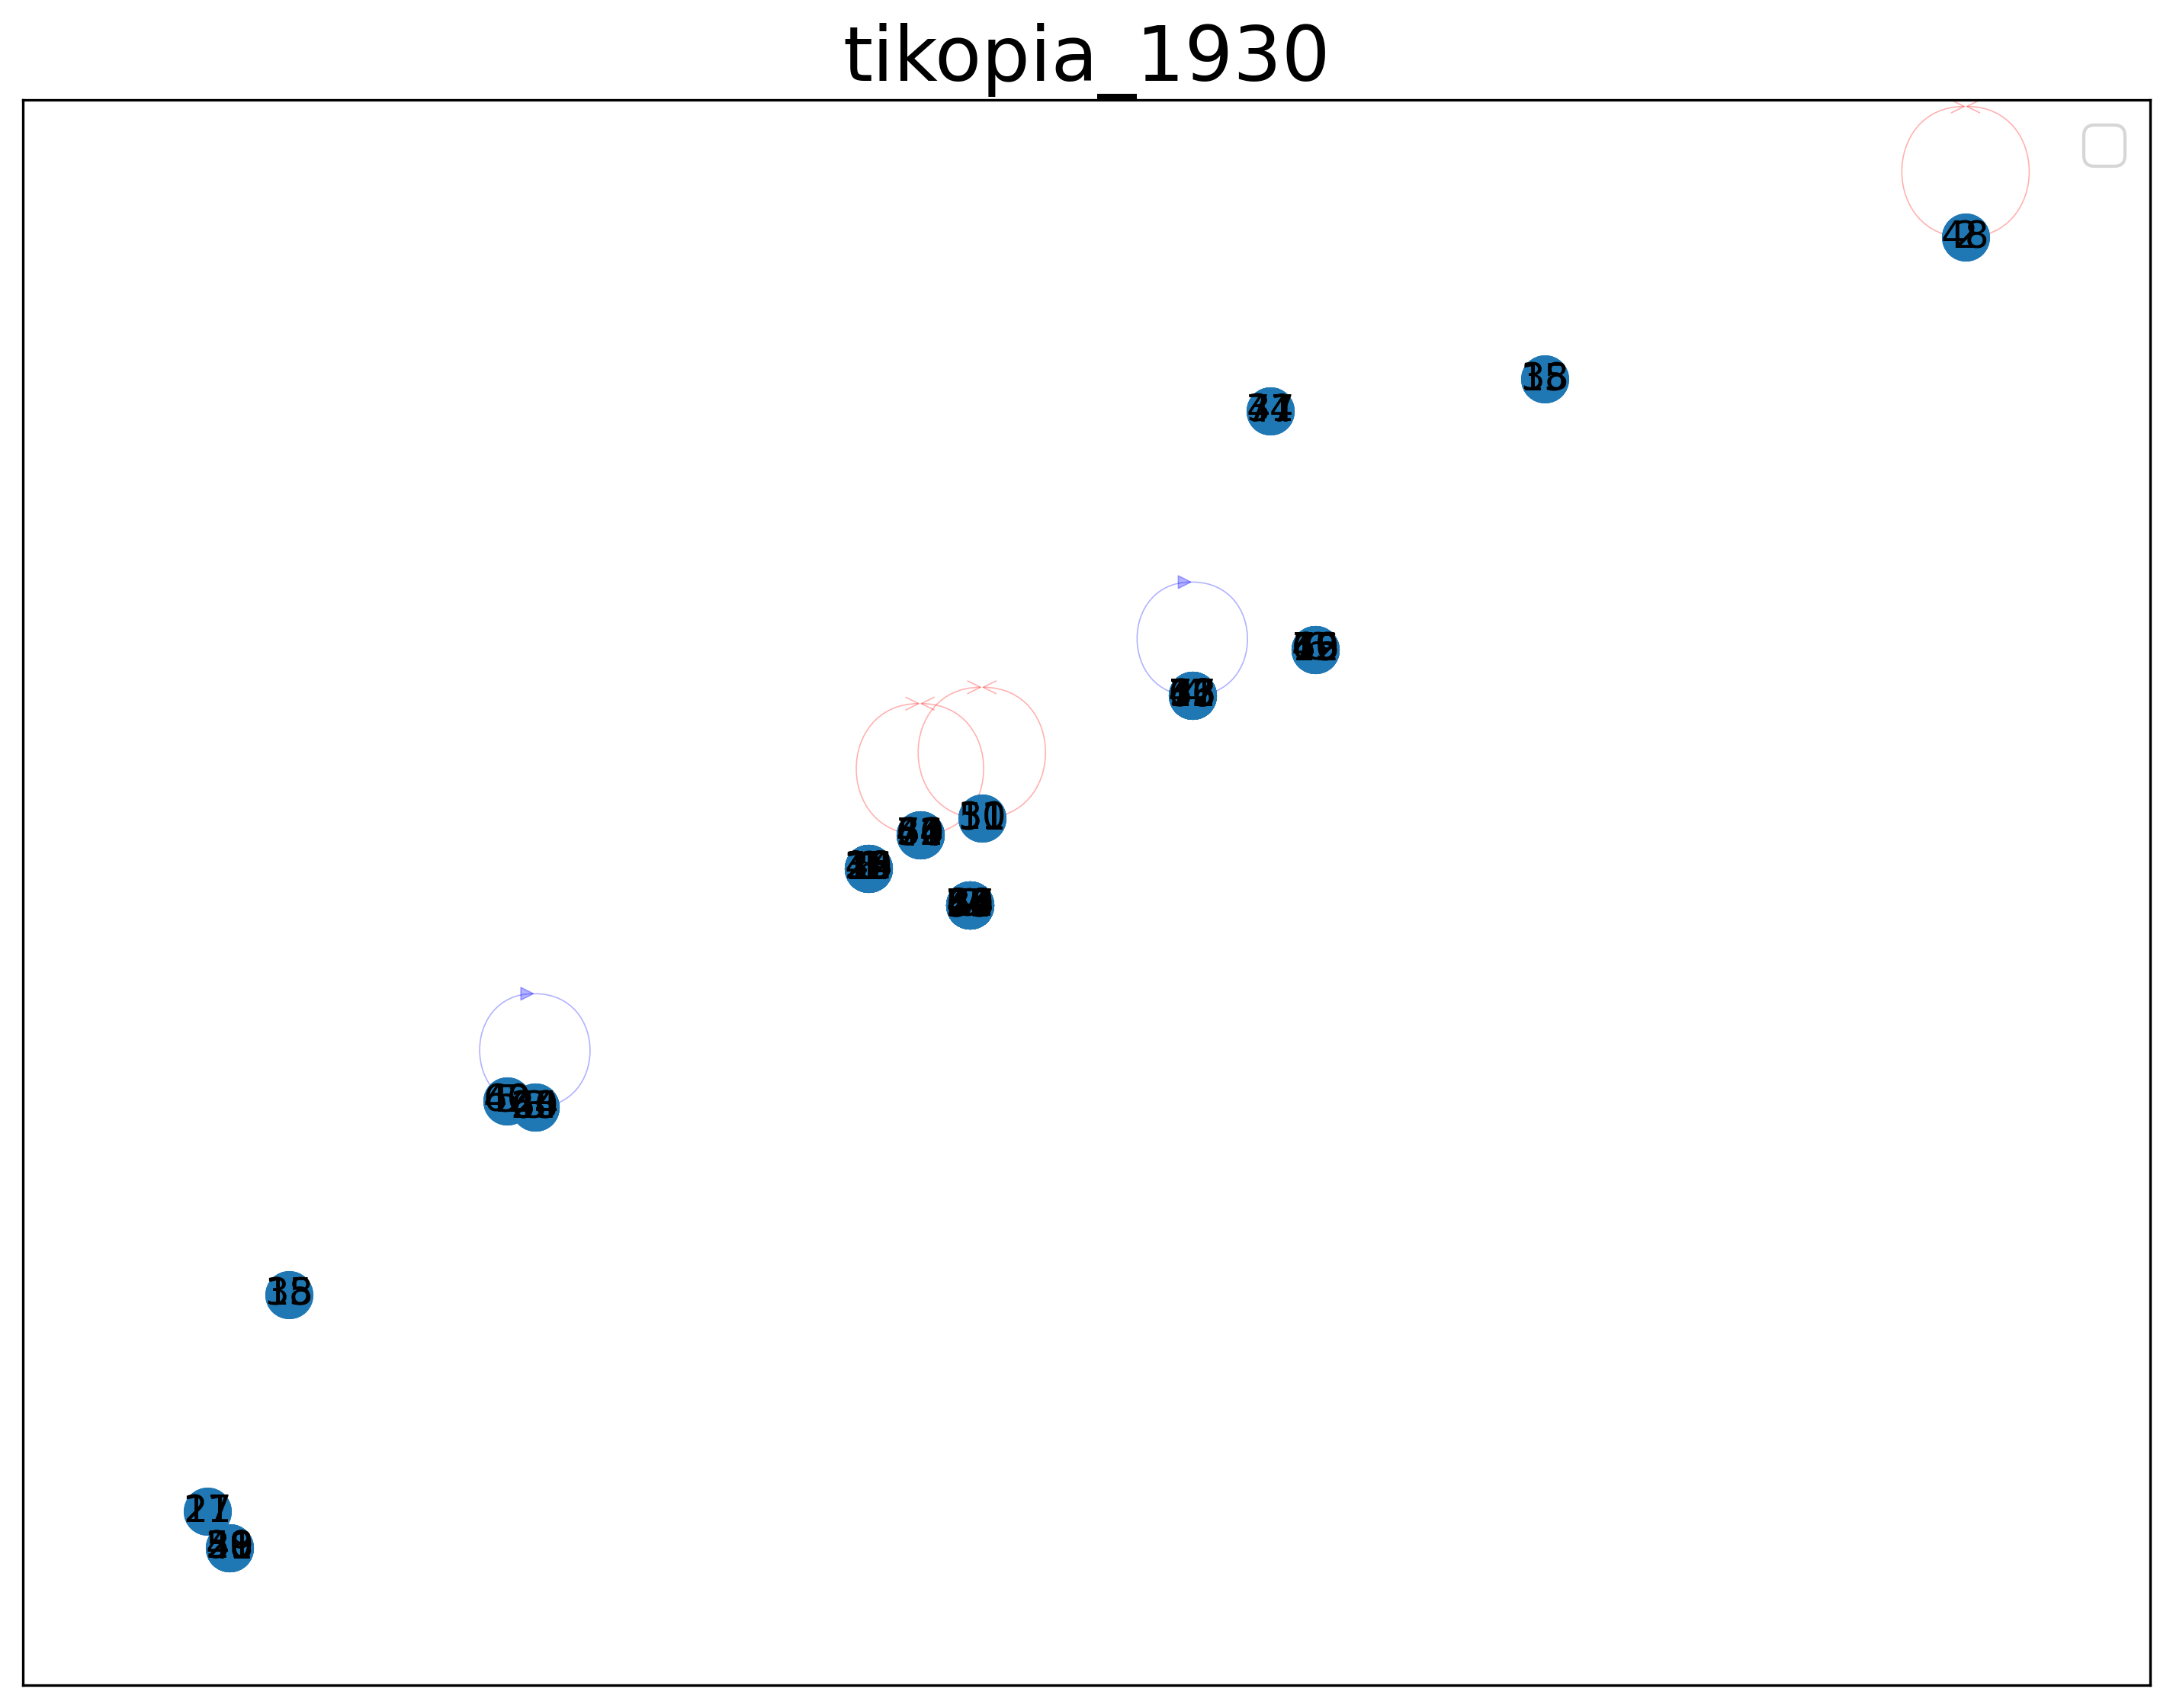

Saved to: target_network_visualizations\tikopia_1930_family_network.png


In [41]:
if __name__ == "__main__":
    # Get a list of all the data sets we can work with
    data_sets = [x[:-4] for x in os.listdir("Kolton_distances")]  # get from folder, excluding .txt part (last 4 characters)

    name = np.random.choice(data_sets)   # Get a random data set
    name = "tikopia_1930"
    # name = "arawete"
    # name = "kelkummer"
    # name = "dogon_boni"

    # Example on how to run the model
    starting_size = 50
    family = HumanFamily(name)   # Gathers data from the kelkummer model and saves it into the object
    family.make_model(starting_size, fixed=True, method="ValidNetworkX")   # Actually runs the model and creates the graph (pass in initial starting size)
    # family.build_single_component()    # Builds a single component and returns it (not necessary for most of our analysis)
    # print(family.G)
    # nx.draw(family.G)
    # plt.savefig('output/{}.png'.format(name))
    family.draw_paj_graph(name,
                          title=name,
                          out_directory='target_network_visualizations',
                          file_name=name,
                          node_size=40,
                          layout=graphviz_layout,
                          layout_args=['dot'],
                          edge_width=.4,
                          alpha=0.6
                          )